### Swetha Chandrasekar
012497628 <br>
swetha.chandrasekar@sjsu.edu
### Project Alternus vera
### factor: party affliation
<h3> In this note book, for the project of Alternus vera, <br><br><br>
-> <font color=orange> In Section 1, we will define and model the factor of <font color=red><u><i>party affliation</i></u></font>.
This vector will be used in the polynomial for fake news prediction.</font> <br><br>
<font color=green>
-> In Section 2, we will try to build a generative model to predict a *statement* that a politician might make in response to a topic/text and list down the challenges in it.<br></font> <br><br>
<font color=blue>
-> In Section 3, we will use the vector modeled after party affiliation and compute coefficients (weights) to predict fake news.<br>
</font>
 </h3>
 
### Formal Business Problem Statement: 

Party affliation of the news maker is an important factor in deciding the credibility of the news or statement.
It is important to model the factor of Party affliation while fact checking the news.<br><br>
<i><u>
Given the text of the statement, location, title of the speaker and the venue of the statement, can we model the factor of party affliation as a vector? </u></i>

### What is party affliation? 
Party refers to an organization, a formal or informal group of like minded members with similar policies and principles and stances on major political issues.
Inferring the Party affliation of a person can help infer the person's stand on major political issues and principles.
Example: 
1. republicans:  leaning right of the political spectrum with support to pro-life, free-market, lesser spending by government. 
2. democrats  leaning left of the political spectrum with explicit suppport to LGBT, relatively more spending by the government by increasing taxes.
<b>Party affliation is not merely confined to the major two. Per LIAR-LIAR dataset, There are 23 more party affliations in addition to the standard republican and democrats.</b>
1. tea-party-member(sub wing within the republican party with fiscal conservative policies)
2. talk-show-host
3. state-official 
4. republican
5. organization
6. ocean-state-tea-party-action
7. none
8. newsmaker
9. Moderate
10. libertarian
11. liberal-party-canada
12. labor-leader
13. journalist
14. independent
15. green
16. government-body
17. education-official
18. democratic-farmer-labor
19. democrat
20. constitution-party
21. columnist
22. business-leader
23. activist
<br>


In [264]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Section 1 : (Modeling the party affliation)

### Datasets used
<font color ="green">

    1. Kaggle dataset "getting real about fake news" https://www.kaggle.com/mrisdal/fake-news
    2. LIAR LIAR dataset
    3. NY times headlines and articles dataset (for the purpose of <b>Data enrichment</b>) https://www.kaggle.com/nzalake52/new-york-times-articles
</font>

### Required python libraries & external data sources
<font color ="blue">
    
    1. gensim (training custom doc embeddings)
    2. glove embeddings 
    3. NLTK
    4. fast ai 

</font>

### General approach (flow of steps)


       1. Initial data exploration and Clean the dataset with standard NLP practices (tokenization, stemming, lemmatization, stop word removal)
       2. Perform LDA for the purpose of distillation on NYTimes articles dataset, fake news datasets
       3. Manually look into  the topics from LDA to create bag of words features and also use word2vec, doc2vec featuers to model the factor of party affliation 
       4. Feature Engineering using the topics from LDA, doc2vec embeddings, categorical features of venue, title and state(location) (please note that we are directly using the doc2vec embeddings as features.
       5. Try various algorithms to predict a vector to assign a range of confidence scores for each party affliation    
<font color ="blue">
<b>
After several iterations, I decided to use a Neural network with Softmax function as it outputs a score for each class of party affliation. (giving out a vector) <br>
I have 4 party affliations. <br>
republican, democrat, no affliation and other<br>
    </b>
</font>



### Initial data exploration on LIAR LIAR dataset for party affliation (there are 25 different affliations)

In [37]:
print ("Number of records in LIAR LIAR dataset:",len(pd.read_csv('train.tsv', names=headers, delimiter='\t')))
print ("Number of records in NY Times headlines dataset:",len(pd.read_csv('NYT_headlines.txt', error_bad_lines=False, delimiter='\t')));
print ("Number of records in Kaggle Fake news dataset:", len(pd.read_csv('fake.csv', error_bad_lines=False, delimiter=',')))


Number of records in LIAR LIAR dataset: 10240
Number of records in NY Times headlines dataset: 9335
Number of records in Kaggle Fake news dataset: 12999


14


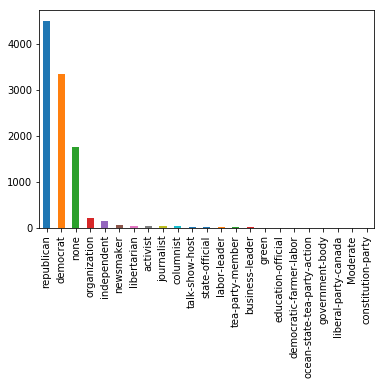

In [123]:
train_path = Path('.')
import pandas as pd
headers = ['id','label','statement','subject',
           'speaker','job_title', 'state', 
           'affliation','barely_true','false',
           'half_true', 'mostly_true','pants_on_fire', 
           'venue']
print (len(headers))
train_df = pd.read_csv('train.tsv', names=headers, delimiter='\t')
train_df.affliation.value_counts().plot(kind='bar')#(10)


#### Let us make it coarse grained to 4 (Republican, democrat, no affliation and other)

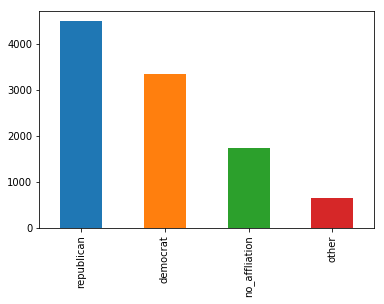

In [127]:
affliation = {}
affliation['republican'] = 'republican'
affliation['democrat'] = 'democrat'
affliation['none'] ='no_affliation'
getPartyAffliation = lambda x : affliation[str(x).lower()] if x in affliation else 'other'
train_df['coarse_party_affliation'] = train_df['affliation'].apply(lambda x: getPartyAffliation(x))
train_df.coarse_party_affliation.value_counts().plot(kind='bar')#(10)


# 1.  Clean and run LDA on NYTimes articles dataset from Kaggle (initial distillation) 
https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
1. Clean the dataset
    1. Tokenization
    2. Stopwords removal
    3. Lemmatization
    4. Stemming
    5. Filter the extremes (too low frequency words and too high frequency words)
2. Perform LDA to find N=10 topics 

<b> Read the NYT headlines dataset which contains articles from 2017 and 2018 </b>

In [128]:
import pandas as pd
from fastai import *
from fastai.text import *
data = pd.read_csv('NYT_headlines.txt', error_bad_lines=False, delimiter='\t');
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text
nyt_headlines_dataset = documents.headline_text.tolist()

### Loading gensim and nltk libraries 
### https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24


In [129]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from fastai import *
from fastai import *
from fastai.text import *
from fastai.tabular import *
from fastai.vision import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [130]:
### performing stemming
from nltk import PorterStemmer 
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return text
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if 'object' in token.strip() or 'dtype' in token.strip() or 'unknown' in token.strip():
                continue
            result.append(lemmatize_stemming(token))
    return result


In [131]:
processed_docs = documents['headline_text'].map(preprocess)
processed_docs[:10]
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

0 expansive
1 finding
2 forgotten
3 niger
4 people
5 view
6 curse
7 dreaded
8 trump
9 descent
10 dictatorship


[]

#### Let us look into the word cloud of processed text in each doc before running LDA 

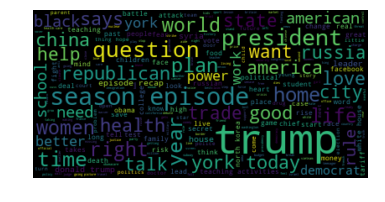

In [132]:
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = ""

for doc in processed_docs:
    text= text + " " + ' '.join(doc)
    
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="black").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


<b> Run LDA on NY times dataset </b>

In [133]:
lda_model1 = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=1, workers=4)
for idx, topic in lda_model1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.058*"trump" + 0.025*"china" + 0.021*"city" + 0.020*"state" + 0.020*"trade" + 0.018*"race" + 0.018*"facebook" + 0.017*"democrats" + 0.017*"data" + 0.015*"woman"
Topic: 1 
Words: 0.104*"trump" + 0.044*"season" + 0.036*"episode" + 0.029*"home" + 0.017*"love" + 0.017*"little" + 0.017*"tariffs" + 0.015*"rules" + 0.015*"food" + 0.013*"trade"
Topic: 2 
Words: 0.036*"going" + 0.034*"life" + 0.030*"season" + 0.027*"episode" + 0.024*"trump" + 0.024*"america" + 0.024*"year" + 0.019*"picture" + 0.017*"women" + 0.016*"help"
Topic: 3 
Words: 0.096*"trump" + 0.028*"president" + 0.018*"good" + 0.018*"party" + 0.018*"politics" + 0.017*"play" + 0.017*"questions" + 0.016*"love" + 0.016*"living" + 0.015*"family"
Topic: 4 
Words: 0.129*"trump" + 0.035*"house" + 0.026*"north" + 0.023*"korea" + 0.020*"chief" + 0.020*"power" + 0.018*"student" + 0.017*"variety" + 0.017*"white" + 0.015*"news"
Topic: 5 
Words: 0.035*"right" + 0.028*"york" + 0.026*"trump" + 0.024*"plan" + 0.021*"russia" + 0.019

# 2.   Clean and run LDA on  fake news dataset from Kaggle (initial distillation) 
1. Clean the dataset
    1. Tokenization
    2. Stopwords removal
    3. Lemmatization
    4. Stemming
    5. Filter the extremes (too low frequency words and too high frequency words)
2. Perform LDA to find N=10 topics 

In [134]:
data = pd.read_csv('fake.csv', error_bad_lines=False);
data_text = data[['title','text']]
data_text['headline_text'] =  data[['title', 'text']].apply(lambda x: ''.join(str(x)).strip().lower().replace('title', '').replace('text',''), axis=1)
data_text = data_text[['headline_text']]
data_text['index'] = data_text.index

documents = data_text
documents.head()
kaggle_fake_news_dataset = data.title.tolist()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Preprocess the document before applying LDA

In [135]:
processed_docs = documents['headline_text'].map(preprocess)
processed_docs[:10]
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

0 busted
1 millions
2 muslims
3 print
4 stole
5 attorney
6 general
7 loretta
8 lynch
9 plead
10 breaking


[(867, 3)]

#### Let us look into the word cloud of processed text in each doc before running LDA 


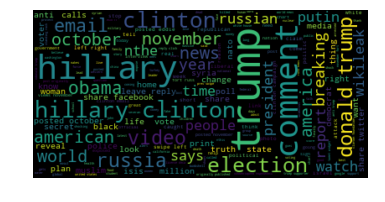

In [136]:
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = ""

for doc in processed_docs:
    text= text + " " + ' '.join(doc)
    
wordcloud = WordCloud(max_font_size=50, max_words=1000, background_color="black").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


##### Run LDA on fake _news dataset from kaggle

In [137]:
lda_model2 = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=1, workers=4)
for idx, topic in lda_model2.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"world" + 0.016*"news" + 0.016*"november" + 0.014*"trump" + 0.012*"clinton" + 0.011*"vote" + 0.011*"october" + 0.010*"media" + 0.009*"obama" + 0.008*"breaking"
Topic: 1 
Words: 0.054*"clinton" + 0.048*"hillary" + 0.037*"trump" + 0.019*"wikileaks" + 0.011*"donald" + 0.011*"syria" + 0.011*"email" + 0.010*"october" + 0.010*"comments" + 0.010*"president"
Topic: 2 
Words: 0.049*"november" + 0.039*"trump" + 0.026*"october" + 0.018*"news" + 0.016*"posted" + 0.014*"police" + 0.012*"donald" + 0.011*"russia" + 0.010*"media" + 0.009*"real"
Topic: 3 
Words: 0.054*"trump" + 0.029*"hillary" + 0.022*"clinton" + 0.021*"email" + 0.018*"america" + 0.015*"comment" + 0.012*"home" + 0.012*"november" + 0.010*"know" + 0.010*"president"
Topic: 4 
Words: 0.039*"november" + 0.024*"trump" + 0.020*"comment" + 0.016*"share" + 0.012*"october" + 0.011*"clinton" + 0.011*"email" + 0.011*"posted" + 0.010*"news" + 0.010*"reply"
Topic: 5 
Words: 0.036*"trump" + 0.021*"clinton" + 0.014*"putin" + 0.0

### In the interest of keeping this notebook concise, I am listing down the ideas tried in observations list and have added the code only for ideas that worked.

Observations:
1. LDA helped in distillation and understand the topics in the corpus BUT DID not help in creating useful features.
2. Logistic regression, random forest, decision tree were all outperformed by Neural Network with softmax
3. Confusion matrix code in the library has a bug in the UX output but is working correctly.

### how to reproduce my result?
1. Create a corpus of text based on 3 datasets (LIAR LIAR statement, kaggle getting real on fake news headlines, NY times article statement headlines).
2. Use Gensim to generate custom doc2vec embeddings of length 10 for each document. 
3. Use the doc2vec embeddings as a feature directly.
4. In addition to that, use categorical features based on the venue where the person made the statement, state to which the person belongs to, titles of the person
5. Since its multi class classification with softmax, accuracy was used for evaluating the model.

In [114]:
train_path = Path('.')
import pandas as pd
headers = ['id','label','statement','subject',
           'speaker','job_title', 'state', 
           'affliation','barely_true','false',
           'half_true', 'mostly_true','pants_on_fire', 
           'venue']
print (len(headers))
train_df = pd.read_csv('train.tsv', names=headers, delimiter='\t')
valid_df = pd.read_csv('valid.tsv', names=headers, delimiter='\t')
test_df = pd.read_csv('test.tsv',names=headers, delimiter='\t')
train_df['statement'].head()

14


0    Says the Annies List political group supports ...
1    When did the decline of coal start? It started...
2    Hillary Clinton agrees with John McCain "by vo...
3    Health care reform legislation is likely to ma...
4    The economic turnaround started at the end of ...
Name: statement, dtype: object

### Let us prepare training data to generate  custom embeddings word vectors from the following datasets
1. training set of LIAR-LIAR dataset
2. NY times articles
3. fake news kaggle dataset

In [138]:
### Combine all the text into a single corpus
word_vector_input_dataset = []
word_vector_input_dataset = train_df.statement.tolist() + nyt_headlines_dataset + kaggle_fake_news_dataset

### let us train Doc2vec embeddings


In [139]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
data = word_vector_input_dataset
tagged_data = []
exception_count = 0
for i, _d in enumerate(data):
    try:
        tagged_data.append(TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]))
    except:
        exception_count+=1
### Train doc2vec embeddings 
print ("Total number of custom documents:",len(tagged_data))
max_epochs = 10
vec_size = 10
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=10,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v1.model")
print("Model Saved")

Total number of custom documents: 31894


/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Model Saved


### Let us look into embeddings for a sample text. (Fake news: obama supports third trimester abortion)

In [142]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
text = "obama supports third trimester abortion"
dvmodel= Doc2Vec.load("d2v.model") ### Using a earlier trained model d2v.model 
test_sentence= [dvmodel.infer_vector(word_tokenize(text))]
print (test_sentence)

[array([ 0.032013, -0.230509, -0.284658, -0.02118 , -0.155593, -0.042149, -0.043211, -0.061751,  0.041941,  0.249907],
      dtype=float32)]


### let us try to train a multi layer neural network on these embeddings + Categorical variables (state, venue, title)

In [143]:
training_statements = train_df.statement.tolist()
tr_affliation = train_df.affliation.tolist()
validation_statements = valid_df.statement.tolist()
testing_statements = test_df.statement.tolist()
training_statement_wv = []
testing_statement_wv=[]
validation_statement_wv = []
for statement in training_statements:
    training_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
for statement in testing_statements:
    testing_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
for statement in validation_statements:
    validation_statement_wv.append(dvmodel.infer_vector(word_tokenize(statement)))
v_affliation = valid_df.affliation.tolist()
t_affliation = test_df.affliation.tolist()

In [144]:
#train_df.venue.value_counts()

In [145]:
## Training dataframe
dataframe = pd.DataFrame(training_statement_wv)
dataframe['affliation'] = pd.Series(tr_affliation)
dataframe['state'] = pd.Series(train_df.state)
dataframe['job_title'] = pd.Series(train_df.job_title)
dataframe['venue'] = pd.Series(train_df.venue)
affliation = {}
affliation['republican'] = 'republican'
affliation['democrat'] = 'democrat'
affliation['none'] ='no_affliation'
getPartyAffliation = lambda x : affliation[str(x).lower()] if x in affliation else 'other'
dataframe['coarse_party_affliation'] = dataframe['affliation'].apply(lambda x: getPartyAffliation(x))
dataframe = dataframe[[0,1,2,3,4,5,6,7,8,9,'coarse_party_affliation','state', 'job_title','venue']]
## testing dataframe
test_dataframe = pd.DataFrame(testing_statement_wv)
test_dataframe['affliation']= pd.Series(t_affliation)
test_dataframe['coarse_party_affliation'] = test_dataframe['affliation'].apply(lambda x: getPartyAffliation(x))
test_dataframe['state'] = pd.Series(test_df.state)
test_dataframe['job_title'] = pd.Series(test_df.job_title)
test_dataframe['venue'] = pd.Series(test_df.venue)
test_dataframe = test_dataframe[[0,1,2,3,4,5,6,7,8,9,'coarse_party_affliation','state','job_title','venue']]
print (test_dataframe.columns, dataframe.columns)

Index([                        0,                         1,
                               2,                         3,
                               4,                         5,
                               6,                         7,
                               8,                         9,
       'coarse_party_affliation',                   'state',
                     'job_title',                   'venue'],
      dtype='object') Index([                        0,                         1,
                               2,                         3,
                               4,                         5,
                               6,                         7,
                               8,                         9,
       'coarse_party_affliation',                   'state',
                     'job_title',                   'venue'],
      dtype='object')


,0,1,2,3,4,5,6,7,8,9,coarse_party_affliation,state,job_title,venue
1262,0.244162,-0.281743,-0.495616,-0.305135,-0.459967,0.178259,-0.281405,0.004780,0.191462,-0.132466,republican,Florida,Governor,a news conference
1263,0.200431,-0.142449,-0.178456,0.487778,-0.102598,-0.053594,0.150294,0.004708,0.127763,0.074385,democrat,Missouri,Governor,"on ABC's ""This Week"""
1264,-0.075262,-0.169445,-0.167050,-0.297144,-0.060021,0.014687,0.110860,-0.248512,0.050316,0.004291,other,Rhode Island,"senior fellow, Foreign Policy Research Institute",a commentary in The Providence Journal
1265,0.355638,0.270046,-0.572722,-0.193535,0.144767,0.063904,-0.110297,0.325544,-0.073923,0.760320,republican,Ohio,"Governor of Ohio as of Jan. 10, 2011",a news conference
1266,0.448178,0.010069,-0.942186,-0.205982,-0.125095,0.427892,-0.520476,0.653607,0.423805,0.214846,democrat,NaN,NaN,an interview with NJToday


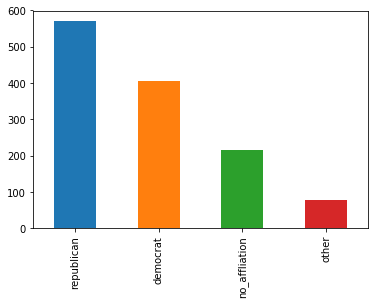

In [146]:
#dataframe.affliation.value_counts().plot(kind='bar')
test_dataframe.coarse_party_affliation.value_counts().plot(kind='bar')#(10)
test_dataframe.tail()

,0,1,2,3,4,5,6,7,8,9,coarse_party_affliation,state,job_title,venue
0,0.081132,-0.259579,-0.238088,-0.105465,-0.117950,-0.269463,-0.142632,0.143994,-0.116476,0.489924,republican,Texas,State representative,a mailer
1,0.586141,0.201556,0.153140,-0.710415,0.306525,0.242623,0.024546,0.185123,-0.408032,0.789099,democrat,Virginia,State delegate,a floor speech.
2,0.331010,-0.401690,0.006383,-0.358717,-0.155976,-0.162591,-0.195382,-0.285321,-0.191991,0.635423,democrat,Illinois,President,Denver
3,0.008006,0.202580,-0.631342,-0.055091,-0.182649,-0.242900,-0.244330,0.079733,0.097898,0.078868,no_affliation,NaN,NaN,a news release
4,0.345234,-0.038455,-0.065026,-0.056599,-0.115273,0.135520,-0.060791,0.090700,-0.253953,0.357860,democrat,Florida,NaN,an interview on CNN


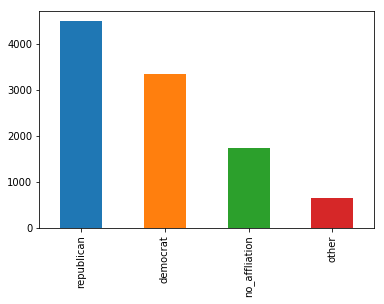

In [147]:
dataframe.coarse_party_affliation.value_counts().plot(kind='bar')
dataframe.head()

In [148]:
path= Path()
X = pd.concat([test_dataframe,dataframe])
X.columns = ['0','1','2','3','4','5','6','7','8','9','coarse_party_affliation','state','job_title','venue']
print (X.columns)
print(len(X))
print(len(dataframe))
print(len(test_dataframe))
test_dataframe.head()
### Categorical features
cat_names= ['state','job_title','venue']
### continuos features
cont_names = ['0','1','2','3','4','5','6','7','8','9']

test = TabularList.from_df(X.iloc[0:1267].copy(), path=path, cat_names=None, cont_names=cont_names)
df_test_copy = X.iloc[0:1267]
X.head()
test_df.state.value_counts()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       'coarse_party_affliation', 'state', 'job_title', 'venue'],
      dtype='object')
11507
10240
1267


Texas                   124
Florida                 117
Wisconsin               101
New York                 85
Illinois                 68
Ohio                     68
Georgia                  56
Virginia                 51
Rhode Island             42
Oregon                   38
New Jersey               30
Arizona                  24
Massachusetts            22
Pennsylvania             15
Kentucky                 13
Delaware                 11
New Hampshire            11
California               10
Washington, D.C.         10
Maryland                  8
Minnesota                 8
Missouri                  8
Alaska                    8
Indiana                   7
Vermont                   7
Arkansas                  7
New Mexico                6
Nevada                    5
North Carolina            5
Tennessee                 5
South Carolina            4
Utah                      3
Connecticut               3
Louisiana                 3
Colorado                  3
Alabama             

In [149]:
path = Path()
procs = [FillMissing, Categorify, Normalize]
dep_var = 'coarse_party_affliation'
valid_idx = list(range(0,1267))
DB = (TabularList.from_df(X, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
      .split_by_idx(valid_idx)
      .label_from_df(cols=dep_var)
      .add_test(test, label=0)
      .databunch())
DB.show_batch(rows=10)

state,job_title,venue,0,1,2,3,4,5,6,7,8,9,target
Florida,"U.S. Representative, Florida District 23",an interview before the CNN/Tea Party Express GOP debate in Tampa,1.1887,1.4919,1.2089,-2.2451,0.0779,1.4955,0.3880,-0.2615,1.1201,-2.0694,democrat
Illinois,President,"Flint, Mich.",0.8073,-0.4049,-1.1139,-0.6258,1.3142,0.2233,-2.3235,-0.2129,-0.4701,0.2212,democrat
Texas,Senator,"the Republican debate in Houston, Texas",-1.1892,2.5077,1.4751,-0.7556,1.2115,2.6713,-1.0320,0.8051,0.9967,0.5820,republican
#na#,#na#,various posts on the Internet,-0.9918,0.5512,0.7585,0.1004,0.3246,-0.4116,0.7592,-0.3539,-0.7654,-1.0771,no_affliation
Wisconsin,#na#,an email,-0.3371,-0.7648,-0.1970,-1.5326,-1.0957,-0.1311,-2.4226,1.0843,0.1569,1.1417,democrat
Florida,U.S. Senator,a speech at the CPAC conference,-1.8716,0.4344,0.9063,-0.8304,-0.4401,-0.3297,0.4927,-0.0250,0.1252,-0.0095,republican
Wisconsin,Wisconsin Senate Minority Leader,a speech,-0.1921,0.1732,0.1500,-0.6233,0.3115,0.1361,0.5822,-0.4212,-0.2416,0.9992,democrat
North Carolina,former senator,"a Democratic debate in Philadelphia, Pa.",1.1353,-0.6210,-1.4944,-2.5708,1.3847,-0.6687,-1.3641,-2.6411,4.3277,1.0626,democrat
Wisconsin,#na#,an interview,-0.6121,1.4481,2.1020,-3.2162,1.2254,0.8513,0.8728,0.7693,-0.8487,0.7180,democrat
North Carolina,Super-PAC,an online video ad.,1.9786,0.1481,-1.0381,-0.0896,-0.1610,0.5201,-0.0703,-0.7226,-0.9172,-0.0974,republican


In [150]:
learn = tabular_learner(DB, layers=[30,15,4],  metrics=accuracy,emb_drop=0.2)


In [151]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(85, 43)
    (1): Embedding(1185, 50)
    (2): Embedding(4346, 50)
  )
  (emb_drop): Dropout(p=0.2)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=153, out_features=30, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=30, out_features=15, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=15, out_features=4, bias=True)
    (7): ReLU(inplace)
    (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [152]:
learn.fit_one_cycle(10,1e-3)


Total time: 00:19
epoch  train_loss  valid_loss  accuracy
1      1.328312    1.282339    0.379637  (00:01)
2      1.141416    1.056281    0.674033  (00:01)
3      0.903809    0.846484    0.691397  (00:01)
4      0.649413    0.704851    0.739542  (00:02)
5      0.478237    0.667879    0.748224  (00:01)
6      0.382800    0.641128    0.752960  (00:01)
7      0.318280    0.655060    0.756906  (00:01)
8      0.280843    0.666667    0.751381  (00:01)
9      0.260734    0.655799    0.749013  (00:01)
10     0.246256    0.656225    0.745856  (00:01)



#### Fast ai provides Learning Rate finder to improve models
#### We can use this to find the best learning rate and rerun the model.
#### As you can see at LR = 1e-3, we have the lease loss. Hence, i used a learning rate of 1e-3

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


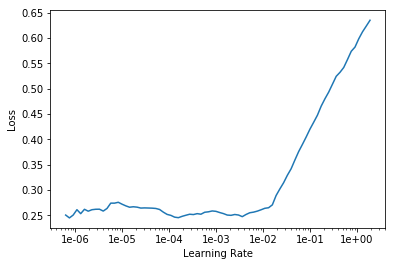

In [154]:
learn.lr_find()
learn.recorder.plot()
#learn.save("NN_model_to_predict_political_Affliation")

### Plot the confusion matrix. (there is a bug in the visual UX)
The order is as follows (1. Republican , 2. democrat, 3. no affliation,4. other)

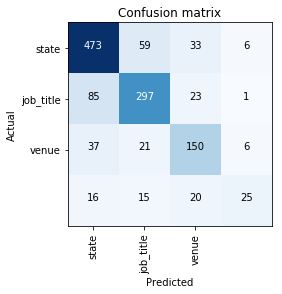

In [155]:
from fastai import *
from fastai.vision import *
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [156]:
learn.load("NN_model_to_predict_political_Affliation")

#print(df_test_copy.iloc[0],learn.predict(df_test_copy.iloc[0]))

texts = ["We stay strong with LGBT community",
         "democrats want to increase taxes and burden the middle class",
         "US population is at its historical low since the 1939 depression",
         "amazon's revenue has grown a lot but they did not raise minimum wage",
         ######################################
         "We must get rid of birth right citizenship to fight illegal immigration",
         "Minimum wage has to be raised while taxing the creamy layer of the wealthy"]
state = ["California", "Florida", "California","Seattle", "Washington D.C", "Florida"]
job_title = ["representative","senator", "blogger","activist", "President", "representative"]
venue = ['a speech','a campaign','a blog posting','news show','a campaign','a campaign']
vectors = []
for text in texts:
    V = dvmodel.infer_vector(word_tokenize(text))
    vectors.append(V)
testX = pd.DataFrame(vectors)
testX["state"] = pd.Series(state)
testX["job_title"] = pd.Series(job_title)
testX["venue"] = pd.Series(venue)
testX.columns= ['0','1','2','3','4','5','6','7','8','9','state','job_title', 'venue']

inference1 =  (texts[0],str(learn.predict(testX.iloc[0])))
inference2 = (texts[1],str(learn.predict(testX.iloc[1])))
inference3 = (texts[2],str(learn.predict(testX.iloc[2])))
inference4 = (texts[3],str(learn.predict(testX.iloc[3])))
inference5 = (texts[4],str(learn.predict(testX.iloc[4])))
inference6 = (texts[5], str(learn.predict(testX.iloc[5])))
testX.head()
texts

['We stay strong with LGBT community',
 'democrats want to increase taxes and burden the middle class',
 'US population is at its historical low since the 1939 depression',
 "amazon's revenue has grown a lot but they did not raise minimum wage",
 'We must get rid of birth right citizenship to fight illegal immigration',
 'Minimum wage has to be raised while taxing the creamy layer of the wealthy']

In [163]:
print (inference1[0],job_title[0],state[0],'\n',inference1[1],'\n--------------------------------------------------------\n')
print (inference2[0],job_title[1],state[1],'\n',inference2[1],'\n--------------------------------------------------------n')
print (inference3[0],job_title[2],state[2],'\n',inference3[1],'\n--------------------------------------------------------n')
print (inference4[0],job_title[3],state[3],'\n',inference4[1],'\n--------------------------------------------------------\n')


We stay strong with LGBT community representative California 
 ('democrat', tensor(1), tensor([0.1429, 0.8246, 0.0089, 0.0236])) 
--------------------------------------------------------

democrats want to increase taxes and burden the middle class senator Florida 
 ('republican', tensor(0), tensor([0.9360, 0.0495, 0.0077, 0.0067])) 
--------------------------------------------------------n
US population is at its historical low since the 1939 depression blogger California 
 ('no_affliation', tensor(2), tensor([0.0932, 0.0616, 0.7051, 0.1401])) 
--------------------------------------------------------n
amazon's revenue has grown a lot but they did not raise minimum wage activist Seattle 
 ('no_affliation', tensor(2), tensor([0.1238, 0.0643, 0.6775, 0.1344])) 
--------------------------------------------------------



### some examples where model fails
#### model is trained on last year data not reflecting current politics
#### model seems to give higher importance to job_title and location

<font color=red> "We must get rid of birth right citizenship to fight illegal immigration" -title:President -location: Washington D.C" 
</font>

#### I added a potential test statement that could be made by current republican president Donald trump but since training data was based from past year, the model predicted the statement is from democrat

<font color=blue>"Minimum wage has to be raised while taxing the creamy layer of the wealthy " -title representative (congress) -location: florida
</font>

#### Similarly i added a statement that could be a potential statement from democrat. however model predicted it to be republican solely due to location and title (florida) and based on past data


In [230]:
### Some cases where the model fails
print (inference5[0],job_title[4],state[4],'\n',inference5[1],'\n--------------------------------------------------------\n')
print(texts[5], job_title[5], state[5],'\n',inference6[1] )


We must get rid of birth right citizenship to fight illegal immigration President Washington D.C 
 ('democrat', tensor(1), tensor([0.0838, 0.8948, 0.0061, 0.0153])) 
--------------------------------------------------------

Minimum wage has to be raised while taxing the creamy layer of the wealthy representative Florida 
 ('republican', tensor(0), tensor([0.4620, 0.2456, 0.2019, 0.0905]))


# Section (2): Can we predict what a politician of particular party affliation might say ?
We need a generative model to predict the text a politician might respond.
1. the datasets handled are not very large
2. lets use a model pre-trained already on large corpus of wikipedia and learn on top of that
3. Wiki-Text103 (RNN trained on wikipedia text)
4. RNNs can learn sequences and generate nth word, given n-1 words.
<br>
Idea inspired from http://karpathy.github.io/2015/05/21/rnn-effectiveness/ <br>
<b>TODO: most of the theory is still black box </b>
Credits: Fast ai 
### Datasets used
<font color ="green">

    1. Tweets during 2016 elections by republicans and democrats (https://www.kaggle.com/kapastor/democratvsrepublicantweets#ExtractedTweets.csv)
    2. LIAR LIAR dataset
    
</font>

## How to reproduce this result?
1. Load the dataset with the tweets and party affliation (Cleaning is implied)
2. transfer learn and train a model on top of pretrained wikipedia model 
3. Use it as a generator to predict a statement from a politician

4. Repeat steps 1,2,3 to train a model using only tweets from republican

In [159]:
import pandas as pd
tweets = pd.read_csv('ExtractedTweets.csv')
tweets.head()
import pandas as pd
headers = ['id','label','statement','subject',
           'speaker','job_title', 'state', 
           'affliation','barely_true','false',
           'half_true', 'mostly_true','pants_on_fire', 
           'venue']
print (len(headers))
liar_train_df = pd.read_csv('train.tsv', names=headers, delimiter='\t')
liar_valid_df = pd.read_csv('valid.tsv', names=headers, delimiter='\t')
liar_test_df = pd.read_csv('test.tsv',names=headers, delimiter='\t')
tweets.head()
text = tweets.Tweet.tolist() + liar_train_df.statement.tolist()
text_data_frame = pd.DataFrame(pd.Series(text))

14


In [39]:
text_data_frame.columns=['statement']
valid_pct = 0.2
cut = int(valid_pct * len(text_data_frame)) + 1
train_lm_df, valid_lm_df = text_data_frame[cut:], text_data_frame[:cut]
train_lm_df.head()

,statement
19341,RT @lasouthbaynews: Manhattan Beach and Hermos...
19342,Kirk's advocacy &amp; Nancy's story--her incre...
19343,"RT @lacdbh: Free, pre-filled sandbags are avai..."
19344,RT @LongBeachPost: .@SupJaniceHahn today offer...
19345,Please keep Cole and his family in your though...


In [160]:
print("total number of tweet and statements:",len(text_data_frame))
#text_data_frame.statement[1]

total number of tweet and statements: 96700


### Clean and preprocess the data and generate data for training a language model

In [42]:
import gensim
from nltk import word_tokenize
#TLMDB = TextLMDataBunch.from_csv(path='./LM_Train/', csv_name='trainLM.txt' ,bs=40)
#TLMDB = TextLMDataBunch.from_df(train_df=train_lm_df, valid_df=valid_lm_df,)
def processTweet(textOfTweet):
    tokens = textOfTweet.lower().strip().split()
    r = []
    for t in tokens:
        if t.startswith("\\"):
            continue
        if ('rt' in t):
            continue
        if ("http" in t or "www" in t or "com" in t):
            continue
        r.append(t)
    textOfTweet = ' '.join(r)
    tokens = word_tokenize(textOfTweet.lower().strip())
    return ' '.join(tokens)
print (processTweet('RT \\n this is an example of http://t.co of bad tweet !!!'))    
text_data_frame['processed_statement'] = text_data_frame['statement'].apply(lambda x : processTweet(str(x)))
PATH= Path()
text_data_frame.head()
data_lm = (TextList.from_df(text_data_frame, PATH, cols=['processed_statement']) 
          .random_split_by_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch(bs=44))

data_lm.save('lm-tokens')


In [43]:
data_lm.show_batch(rows=5)

idx,text
0,xxbos in case you missed it : the @ ephcc was named the texas small chamber of the year & amp ; as the u.s . chamber of the year ! … xxbos i encourage everyone to watch senator @ randpaul discuss the current spending bill on the senate floor right now . su … xxbos we helped az seniors protect themselves from financial fraud at our # seniorsafe event . protect yourself from financ … xxbos representatives of @ liuna from nj emphasized pressing issues for american workers and infrastructure ’ s ability to
1,"the … xxbos # trump 's great wall is a wall of debt . @ xxunk # sotu xxbos @ voices4service : “ we should continue to make national service more accessible to the millions of americans who want to serve their count … xxbos @ usmc : honor the fallen tuesday we lost four marines from @ xxunk during a training exercise in california . capt samuel a. schultz of … xxbos @ replloyddoggett : since 2006 , the average cost for a year of medication for someone with a chronic disease has more"
2,"surging economic optimism '' # taxreform xxbos time ’ s running out ! high school across the hv are encouraged to submit their work to the congressional xxbos i look forward to joining @ vp pence today in detroit to talk about how the tax cuts are benefitting michigan worker … xxbos @ xxunk : us trade deficits vs. us household net 1970 to 2017 , they ' ve risen in xxunk over the last half - century . … xxbos @ xxunk : `` the moment is long overdue for el salvador , the"
3,"a shutdown . today , he 's the one xxunk … xxbos wishing everyone a very happy 2018 . all the best always ! ! ! xxrep 7 — xxunk un feliz 2018 . todo lo mejor en este … xxbos “ we all share the same great american flag ” # sotu 🇺 🇸 🇺 🇸 xxbos @ govwaste : congrats @ repscottperry for being named a “ taxpayer super hero ” - thank you for your hard work ! xxbos it was great to sit down with a # mi11 constituent , troy"
4,"the free flow of ideas is necessary for our economy to thrive . our internet providers should not be able to limit o … xxbos the image of america fellow americans is not something this country or the gop want to see unfolding ever … xxbos @ nancypelosi : today , we announce an ambitious new addition to our plan to give america # abetterdeal . xxbos 95 percent of the gains in the last few years have gone to the top 1 percent . xxbos this morning i joined a forum hosted by @"


### Train a language model to predict the next word

In [48]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.25)
learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

Total time: 01:59
epoch  train_loss  valid_loss  accuracy
1      5.072789    4.787429    0.234515  (00:40)
2      4.684464    4.498495    0.267515  (00:39)
3      4.596628    4.465510    0.270697  (00:40)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


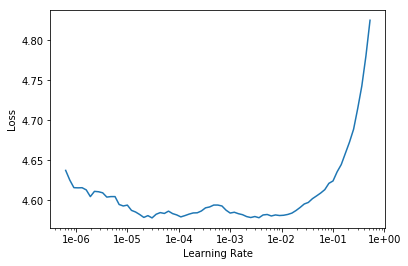

In [49]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [50]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

Total time: 07:49
epoch  train_loss  valid_loss  accuracy
1      4.288502    4.147059    0.306274  (00:46)
2      4.058426    3.961607    0.325709  (00:46)
3      3.880060    3.820597    0.338716  (00:46)
4      3.714250    3.722916    0.349668  (00:46)
5      3.549821    3.667458    0.357371  (00:46)
6      3.408917    3.625586    0.362391  (00:47)
7      3.298213    3.612828    0.364922  (00:46)
8      3.168557    3.608951    0.366264  (00:46)
9      3.110087    3.610060    0.366767  (00:47)
10     3.088340    3.614610    0.366696  (00:47)



In [51]:
learn.save('fine_tuned')
learn.load('fine_tuned');
learn.save_encoder('fine_tuned_enc')


### Let us try to predict what a politician (democrat or republican) might tweet or text for a given statment or topic

In [57]:
def postProcess(str):
    return ' '.join(preprocess(str))

A = (str(learn.predict("Hillary clinton election", 10)))
B  =(str(learn.predict("US 2016 election", 11)))
print (A)
print (B)

Total time: 00:00

Hillary clinton election strongly against the united states that other things to the
US 2016 election rules at the survivors natresources , in negotiations . the team


### Filter the tweets and LIAR dataset to only statements from republican party affliated people
### Retrain the model using only republican text. Transfer learn on top of wikipedia set.

In [72]:
republican_text = tweets[tweets.Party == 'Republican'].Tweet.tolist() + liar_train_df[liar_train_df.affliation == 'republican'].statement.tolist()
r_text_data_frame = pd.DataFrame(pd.Series([processTweet(x) for x in republican_text]))
r_text_data_frame.columns = ['processed_statement']
PATH= Path()
r_data_lm = (TextList.from_df(r_text_data_frame, PATH, cols=['processed_statement']) 
          .random_split_by_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch(bs=42))

r_data_lm.save('r_lm-tokens')

idx,text
0,"xxbos president @ realdonaldtrump levels the playing field in the skies ending qatar 's unfair practices that american … xxbos last night , i voted to keep the government open & amp ; extend child health insurance for 6 years for xxunk kids in hood ri … xxbos @ housegop : good news → this is the last year you will ever have to file your taxes with our old , outdated , and broken tax code . who else … xxbos @ xxunk : large incident in the area of xxunk and hill ."
1,"encourage your students to # xxunk … xxbos in march , the u.s . secretary of agriculture sonny perdue announced that the usda is taking action to assist our xxunk … xxbos hey @ xxunk : i ’ m finally xxunk you ! your beautiful family is of xxunk . thanks for saying hi ! xxbos appreciation your unwavering to ensure safety issues to flight xxunk are heard & amp ; address … xxbos 7 . buyout homes xxunk beyond repair . i homeowners ' decisions to pursue a buyout and will work with my"
2,"i was honored to host one of my favorite events of the year , my annual reception to honor local student … xxbos i was not on the train to west virginia today . my thoughts and prayers are with all those affected by today ’ s accident . xxbos @ xxunk : watch bob xxunk of xxunk member contractor @ des_electronic testify before @ housesmallbiz on american # infrastructure and th … xxbos speaking w / @ khqa about korea and how tax reform will help the hardworking families of our district . xxbos"
3,"than to visit these presidential places in # il16 : 🏠 xxunk home of # reagan in # d … xxbos happy new year ! i hope everyone in # ga12 has a blessed 2018 . xxbos i ve gotten to see the that they did on you . and i ve gotten to see some of the most vicious i ve ever seen of michelle obama talking about you , hillary . xxbos in february , your paycheck may have seen a boost thanks to # taxreform . did you # checkyourcheck ? take"
4,"’ m thankful to god for my wonderful family and friends who xxunk each day , for my amazing staff who make my work a joy … xxbos icymi : debuts “ personal stories from the opioid crisis ” video series in conjunction with today ’ s # fullcmt … xxbos discussing the music modernization act with songwriters from the @ xxunk . thanks for stopping by and performing so … xxbos i recently co - sponsored the rural broadband permitting efficiency act . this legislation makes the process … xxbos @ xxunk : ."
5,"submit your original work of for the congressional xxbos outstanding meeting in my office with large group of retired nassau county xxunk in washington to xxbos more than 100 already promised bonuses , raises and investments since # taxreform was signed into law less … xxbos # us adds 164k jobs and unemployment rate xxunk to 3.9 % . # smallbusinesses are leading the charge throughout our nati … xxbos says hillary xxunk that when the progressive agenda xxunk religious beliefs to the contrary , those beliefs have to be changed . xxbos @ waysandmeansgop"
6,"and ally , spain , especially upon today 's terrorist attack in barcelona . # xxunk xxbos we are all saddened to hear about the # xxunk band bus crash in south # alabama earlier today . let ’ s keep all … xxbos lk “ the shift away from full - time employment by many employers has created lasting effects for the avg . # millennial '' # gopfuture xxbos more good news . this time in the form of $ 15 minimum hourly wage . xxbos says president franklin xxunk roosevelt sent his"
7,"ischua # townhall . looking forward to bringing your ideas back to washington . # ny23 xxbos @ gopleader : the house and senate have agreed to a unified tax plan , and we ’ ll deliver it to the president ’ s desk just in time for christ … xxbos @ xxunk : jim bridenstine is sworn - in as @ nasa ’ s 13th administrator by @ vp pence . check out the first pictures - xxbos @ xxunk : proud of the u.s . center for and ceo xxunk xxunk for receiving"
8,"duty of a patriot is to protect his country from his government . xxbos 🚨 breaking 🚨 royal , va

In [75]:
republican_learn = language_model_learner(r_data_lm, pretrained_model=URLs.WT103, drop_mult=0.25)
republican_learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

Total time: 00:55
epoch  train_loss  valid_loss  accuracy
1      5.443854    5.008534    0.209033  (00:18)
2      4.776983    4.553791    0.247067  (00:18)
3      4.668648    4.509846    0.253336  (00:18)



## Let us try to predict what a republican party member would tweet or say for hillary clinton emails using the generative Language model

In [81]:
A = (str(republican_learn.predict("Hillary clinton emails", 100)))
B  =(str(republican_learn.predict("US 2016 election", 100)))
i = 0
for t in A.split():
    if t != '.':
        i+=1
    else:
        continue
print (A[:i])
i = 0
for t in B.split():
    if t != '.':
        i+=1
    else:
        continue
print (B[:i])

Total time: 00:05

Hillary clinton emails from graduation , is an hour the town hall of the braves by 7 pm – major bus ef
US 2016 election began to a victory panel to the economy of the end of two years at the traditional di


## From the above examples, we can see we do not have sufficient data to generate a text to predict what a politician might say.

# Section (3): Party Affliation Factor into the final polynomial

Datasets used:
1. LIAR LIAR dataset
Packages used
    1. scikit learn
    2. pandas 
    3. fast ai for predicting fake news or not
    4. gensim to get embeddings

In [162]:
import pandas as pd
headers = ['id','label','statement','subject',
           'speaker','job_title', 'state', 
           'affliation','barely_true','false',
           'half_true', 'mostly_true','pants_on_fire', 
           'venue']
print (len(headers))
liar_train_df = pd.read_csv('train.tsv', names=headers, delimiter='\t')
liar_valid_df = pd.read_csv('valid.tsv', names=headers, delimiter='\t')
liar_test_df = pd.read_csv('test.tsv',names=headers, delimiter='\t')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
text = "obama supports third trimester abortion"
dvmodel= Doc2Vec.load("d2v.model") ### Using a earlier trained model d2v.model 
test_sentence= [dvmodel.infer_vector(word_tokenize(text))]
print (test_sentence)

14
[array([ 0.032013, -0.230509, -0.284658, -0.02118 , -0.155593, -0.042149, -0.043211, -0.061751,  0.041941,  0.249907],
      dtype=float32)]


In [174]:
statements = liar_train_df.statement.tolist()
statements_wv = [dvmodel.infer_vector(word_tokenize(x)) for x in statements]

In [198]:
dataframe = pd.DataFrame(statements_wv)
#dataframe['affliation'] = pd.Series(tr_affliation)
dataframe['state'] = pd.Series(train_df.state)
dataframe['job_title'] = pd.Series(train_df.job_title)
dataframe['venue'] = pd.Series(train_df.venue)
dataframe.columns=['0','1','2','3','4','5','6','7','8','9','state','job_title','venue']
dataframe['label'] = pd.Series(train_df.label)

In [199]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,state,job_title,venue,label
0,-0.040440,-0.209226,-0.153631,-0.054188,-0.121167,-0.130126,-0.129729,-0.063752,-0.179557,0.350290,Texas,State representative,a mailer,false
1,0.510760,0.211858,0.077840,-0.773056,0.427822,0.379579,0.177755,0.096135,-0.321731,0.811748,Virginia,State delegate,a floor speech.,half-true
2,0.455578,-0.302601,0.000354,-0.283986,-0.206793,-0.241204,-0.310849,-0.134622,-0.297681,0.604613,Illinois,President,Denver,mostly-true
3,-0.020223,0.183613,-0.467326,0.034525,-0.140986,-0.191915,-0.269147,0.052243,0.118874,0.036981,NaN,NaN,a news release,false
4,0.460637,-0.086866,-0.129500,-0.121533,-0.105674,0.074198,0.051659,0.088362,-0.154161,0.271911,Florida,NaN,an interview on CNN,half-true


In [228]:
learn.load("NN_model_to_predict_political_Affliation")
party_affliation_vector =[]
prediction =[]

for i in range(0,len(dataframe)):
    inference = learn.predict(dataframe.iloc[i])
    prediction.append(inference[0])
    party_affliation_vector.append(inference[2])
    


In [231]:
import numpy as np
party_affliation_vector_for_polynomial= []
for vector in party_affliation_vector:
    v =[]
    for i in vector:
        a = float(i)
        v.append(a)
    vector_for_polynomial.append(v)


In [243]:
training_data_for_polynomia_weights = pd.DataFrame(vector_for_polynomial)
training_data_for_polynomia_weights.columns = ['confidence_republican','confidence_democrat','confidence_no_affliation','confidence_other']
## ignore this field for training. 
training_data_for_polynomia_weights['ground_truth'] = pd.Series(train_df.affliation)
## add prediction
training_data_for_polynomia_weights['predicted_party'] = pd.Series(prediction) 
training_data_for_polynomia_weights.head()


,confidence_republican,confidence_democrat,confidence_no_affliation,confidence_other,ground_truth,predicted_party
0,0.878452,0.066819,0.036805,0.017924,republican,republican
1,0.069644,0.913947,0.004325,0.012084,democrat,democrat
2,0.039919,0.928648,0.007380,0.024053,democrat,democrat
3,0.422190,0.109231,0.287561,0.181017,none,republican
4,0.201960,0.759140,0.012792,0.026108,democrat,democrat


In [244]:
training_data_for_polynomia_weights['fake_news_label'] = pd.Series(train_df.label)
training_data_for_polynomia_weights.head()

,confidence_republican,confidence_democrat,confidence_no_affliation,confidence_other,ground_truth,predicted_party,fake_news_label
0,0.878452,0.066819,0.036805,0.017924,republican,republican,false
1,0.069644,0.913947,0.004325,0.012084,democrat,democrat,half-true
2,0.039919,0.928648,0.007380,0.024053,democrat,democrat,mostly-true
3,0.422190,0.109231,0.287561,0.181017,none,republican,false
4,0.201960,0.759140,0.012792,0.026108,democrat,democrat,half-true


# 1 <- true factual news (true , mostly true, half true)
# 2 <- fake news (false, barely true)

In [245]:
training_data_for_polynomia_weights['label'] = training_data_for_polynomia_weights.fake_news_label.apply(lambda x: 0 if ('barely' in str(x) or 'false' in str(x) )else 1)
training_data_for_polynomia_weights.head()


,confidence_republican,confidence_democrat,confidence_no_affliation,confidence_other,ground_truth,predicted_party,fake_news_label,label
0,0.878452,0.066819,0.036805,0.017924,republican,republican,false,0
1,0.069644,0.913947,0.004325,0.012084,democrat,democrat,half-true,1
2,0.039919,0.928648,0.007380,0.024053,democrat,democrat,mostly-true,1
3,0.422190,0.109231,0.287561,0.181017,none,republican,false,0
4,0.201960,0.759140,0.012792,0.026108,democrat,democrat,half-true,1


In [246]:
features = ['confidence_republican', 'confidence_democrat', 'confidence_no_affliation', 'confidence_other']
X = training_data_for_polynomia_weights[features]
Y = training_data_for_polynomia_weights[['label']]
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X = X.fillna(0);
Y = Y.fillna(0);
scaled_X = scaler.fit_transform(X)
scaled_Y = scaler.fit_transform(Y)

In [254]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_Y, test_size=0.1, random_state=0)
lm = linear_model.LogisticRegression(verbose=1)
model = lm.fit(X_train, y_train)
print (model)
predictions = lm.predict(X_test)

print ("Score:", model.score(X_test, y_test))

[LibLinear]LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False)
Score: 0.9072265625


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Let us look into the coefficients of the Logistic regression output and use that to compute weights for the polynomial

In [256]:
coefficient = []
sum = 0.0
for i in range(0,len(model.coef_[0])):
    print ("LR coefficient", training_data_for_polynomia_weights.columns[i], model.coef_[0][i])
    sum += model.coef_[0][i]
    coefficient.append(model.coef_[0][i])
    

LR coefficient confidence_republican 0.3082593770507061
LR coefficient confidence_democrat 0.7258579188298696
LR coefficient confidence_no_affliation 0.5540037705137325
LR coefficient confidence_other 0.32582887594820803


### normalize these LR coefficients

In [263]:
for i in range(0,len(coefficient)):
    print ("Fake news Weight for affliation ",training_data_for_polynomia_weights.columns[i].replace('confidence','')," in final polynomial:", coefficient[i]*100/sum , " %")

Fake news Weight for affliation  _republican  in final polynomial: 16.105926818202054  %
Fake news Weight for affliation  _democrat  in final polynomial: 37.92460308243379  %
Fake news Weight for affliation  _no_affliation  in final polynomial: 28.945572622222173  %
Fake news Weight for affliation  _other  in final polynomial: 17.02389747714198  %


## These results are strictly based on the dataset